# Quang Phu NGUYEN - 22046596
## Assignment 2 - Main Task
We will build a manifold learning or sometimes called dimensionality reduction model on CIFAR-10 images so that we can visualise images in low dimensional space, say in 2D plane. In this assignment, we use image data CIFAR-10. The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

As we use images, you need to use CNN instead of simple MLP. You are free to choose the structure of the CNN, for example, the number of layers, activation functions etc. In terms of the dimensionality of the manifold, we fix it to be 2, meaning the middle layer (bottle neck layer) of your autoencoder should have only 2 units. The output of this bottleneck layer is usually called the representation of the input. 

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torchvision
import os

from torch.utils.data import random_split, DataLoader

# Load and normalise CIFAR10
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Neural network training
from torch import nn
from torch.nn import ConvTranspose2d

### Task 1: Randomly select 3 classes with 100 images per class for this assignment

In [4]:
# Loading data
torch.manual_seed(412) # Constant seed
dataset = CIFAR10(os.getcwd(), transform = transforms.ToTensor(), download = True)

random.seed(22)
classes = random.sample(range(9),3)
classes # Classes Bird (2), Cat (3), Airplane (0)

Files already downloaded and verified


[2, 3, 0]

In [5]:
# Change target 2,3,0, into 2,1,0, that will easily deal when working classification
# New target of Cars is 11 so can putting Cats to target 1
dataset.targets = [11 if target == 1 else target for target in dataset.targets]
dataset.targets = [1 if target == 3 else target for target in dataset.targets]

In [6]:
class1_index = list(np.where( np.array(dataset.targets) == 0)[0])[0:100] # 100 row index for Airplane
class2_index = list(np.where( np.array(dataset.targets) == 1)[0])[0:100] # 100 row index for Cat (Used to be 3)
class3_index = list(np.where( np.array(dataset.targets) == 2)[0])[0:100] # 100 row index for Bird
allClasses_index = class1_index + class2_index + class3_index # List but in order: Bird, Cat, Airplane

# Shuffle the list above to make 3 classes distribute randomly
for i in range(20):
    random.Random(i).shuffle(allClasses_index)

# Extract the table with selected indexes
dataset_filtered = torch.utils.data.Subset(dataset, allClasses_index)

In [7]:
# Divide into 3 dataset with proportion 200-95-5
trainingSet, validatingSet, testingSet = torch.utils.data.random_split(dataset_filtered, [200,95,5])

# Load data
train_Loader    = torch.utils.data.DataLoader(trainingSet  , batch_size = 5, shuffle = True) 
validate_Loader = torch.utils.data.DataLoader(validatingSet, batch_size = 5, shuffle = True) 
test_Loader     = torch.utils.data.DataLoader(testingSet   , batch_size = 5, shuffle = False)

### Task 2: Build the autoencoder model using CNN with functioning training code
Some formulae:
- Conv2d: $Output Size = \frac{Input Size + 2 \times Padding - Kernel Size}{Stride} + 1$
- ConvTranspose2d: $Output Size = (Input Size -1)*Stride-2\times Padding + Kernel Size$
- $Stride$ is $1$ if it is not mentioned
- $Padding$ is $0$ if it is not mentioned
- Choose $3\times 3$ for $KernelSize$ to have more optimal object detection

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Original Format: 3 channels, Size 32 x 32
        self.encode_layer = nn.Sequential( # Use nn.Conv2d for feature extraction and downsampling
            # Originally 3 x (32 x 32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32 x (32 x 32)
            nn.BatchNorm2d(32), # Normalise the output 32 channels and improve training efficiency
            nn.ReLU(inplace = True), # Replace negative value with 0
            
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1), # 16 x (32 x 32)
            nn.ReLU(inplace = True),
            # Reduce spacial dimensionality and Capture the most significant value
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 channels, Size 16 x 16

            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1), # 8 x (16 x 16)
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 8 channels, Size 8 x 8
            ) # Then flatten step for bottle neck layer
        
        # Requirement satisfied: Fix 2 unit in the bottle neck layer
        self.bottle_neck = nn.Sequential(
            nn.Linear(8 * 8 * 8, 2), # Compress
        )
        
        self.decode_layer = nn.Sequential( # Use result from encode_layer, not bottle_neck
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=2, stride=2), # 16 x (16 x 16)
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=2, stride=2), # 32 x (32 x 32)
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, padding=1), # 3 x (32 x 32)
            nn.ReLU(inplace = True) # Change value domain between 0 and 1
        )

    def forward(self, x):
        x = self.encode_layer(x)       
        
        feature = x.view(x.size(0), -1)     
        feature = self.bottle_neck(feature)        
    
        x = self.decode_layer(x)       # Decode layer (3x32x32)

        return x, feature

In [10]:
def train_model(optimiser, model, loss_function, 
                   train_Loader, validate_Loader, mode,
                   n_epochs = 10, fplotloss = True, filename = ""):
    # Tracking the best model to evaluate on the validating step
    train_losslist = []
    val_losslist = []
    val_loss_min = np.Inf # Largest number so can easily store and update new minimum value

    print("Starting training cycles.")
    for epoch in [*range(n_epochs)]: # 10 by default (Larger number take more time)
        # Reset loss every epoch
        train_loss = 0.0
        val_loss = 0.0

        # Train model
        model.train()
        for data, target in train_Loader:
            optimiser.zero_grad() # Reset the gradients of all to zero
            output = model(data) # Predicted outputs using above model

            if mode == 'AE': # Autoencoder
                loss = loss_function(output[0], data)
            else: # Classification
                loss = loss_function(output[0], target)

            loss.backward() # Compute gradients of the loss with respect to model parameters
            
            optimiser.step() # Update parameters
            train_loss += loss.item()*data.size(0) # Update training loss

        # Validate model
        model.eval()
        for data, target in validate_Loader:
            output = model(data) # Predicted outputs using above model

            if mode == 'AE': # Autoencoder
                loss = loss_function(output[0], data)
            else: # Classification
                loss = loss_function(output[0], target)
            val_loss += loss.item()*data.size(0) # Update validating loss

        # Calculate average losses
        train_loss = train_loss/len(train_Loader.dataset)
        val_loss = val_loss/len(validate_Loader.dataset)
        
        # Store the loss for each epoch
        train_losslist.append(train_loss)
        val_losslist.append(val_loss)

        # Print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, val_loss))
        
        # Save/Update model every time find a new minimum loss
        if val_loss <= val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    val_loss_min, val_loss))
            torch.save(model.state_dict(), 'bestmodelAE'+filename+'.pt')
            val_loss_min = val_loss
    
    # Plot training and validation loss if fplotloss=True
    if fplotloss:
        plt.plot(list(range(n_epochs)), train_losslist)
        plt.plot(list(range(n_epochs)), val_losslist)
        plt.ylim((min(train_losslist+val_losslist),max(train_losslist+val_losslist)))
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Performance of the model")
        plt.legend(["Training loss","Validation loss"])
        plt.show()
    
    print('Training process has finished.') # Process is complete.

Starting training cycles.
Epoch: 0 	Training Loss: 0.135969 	Validation Loss: 0.106558
Validation loss decreased (inf --> 0.106558).  Saving model ...
Epoch: 1 	Training Loss: 0.081396 	Validation Loss: 0.078728
Validation loss decreased (0.106558 --> 0.078728).  Saving model ...
Epoch: 2 	Training Loss: 0.067681 	Validation Loss: 0.070716
Validation loss decreased (0.078728 --> 0.070716).  Saving model ...
Epoch: 3 	Training Loss: 0.064290 	Validation Loss: 0.068322
Validation loss decreased (0.070716 --> 0.068322).  Saving model ...
Epoch: 4 	Training Loss: 0.063510 	Validation Loss: 0.067686
Validation loss decreased (0.068322 --> 0.067686).  Saving model ...
Epoch: 5 	Training Loss: 0.063354 	Validation Loss: 0.067524
Validation loss decreased (0.067686 --> 0.067524).  Saving model ...
Epoch: 6 	Training Loss: 0.063268 	Validation Loss: 0.067378
Validation loss decreased (0.067524 --> 0.067378).  Saving model ...
Epoch: 7 	Training Loss: 0.063236 	Validation Loss: 0.067201
Validati

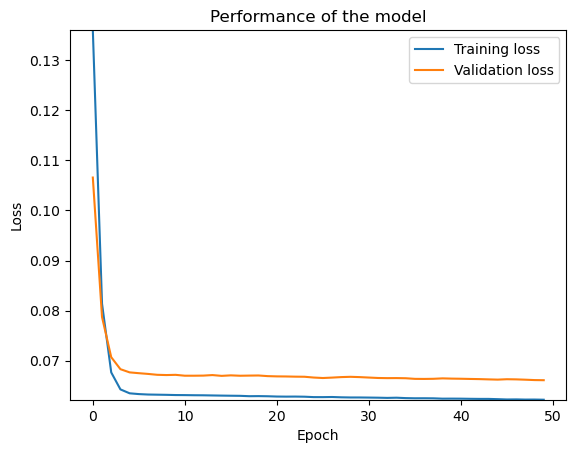

Training process has finished.


In [11]:
modelAE = Autoencoder()
optimiser = torch.optim.SGD(modelAE.parameters(), lr=.01)

train_model(optimiser, modelAE, nn.MSELoss(),    
            train_Loader, validate_Loader, mode = 'AE', 
            n_epochs=50, fplotloss=True, filename='_smallAE');

In [12]:
# Load the parameter that make loss minimum in the previous iterations
state_dict = torch.load('bestmodelAE_smallAE.pt')
model_dict = modelAE.state_dict()
modelAE.load_state_dict(model_dict)

<All keys matched successfully>

### Task 3: Plot the learnt images 2D coordinates (normally called embeddings in machine learning) of all images in training with each class denoted by a symbol.

### Task 4: Randomly select 5 images that are not in the training set and obtain their 2D representations, add them to the plot produced in task 3 and describe what do you think about them in terms of their locations in relations to others.

In [14]:
print('Before change:', classes) # But remember that class 3 is already changed into 1
classes[1] = 1
print('After change :', classes)

Before change: [2, 3, 0]
After change : [2, 1, 0]


In [15]:
symbols = {0: 's', 1: '^', 2: 'o'}
colours = {0: 'g', 1: 'r', 2: 'k'}

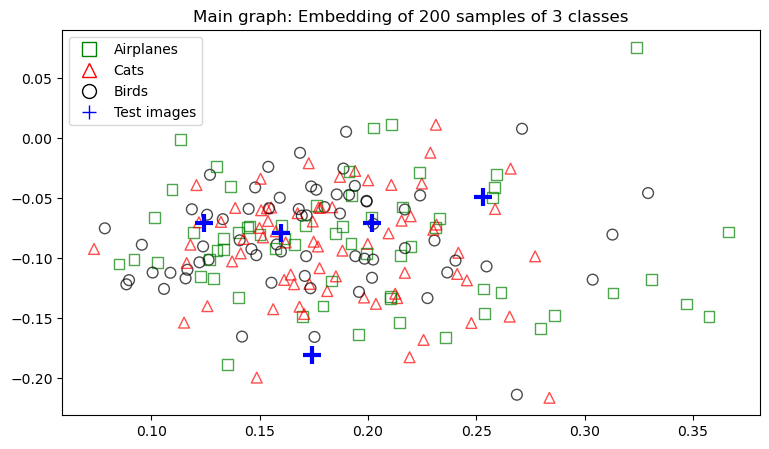

In [16]:
class0 = plt.Line2D([0], [0], marker='s', color='g', label='Airplanes', 
                    linestyle='none', markerfacecolor='none', markersize=10)
class1 = plt.Line2D([0], [0], marker='^', color='r', label='Cats', 
                    linestyle='none', markerfacecolor='none', markersize=10)
class2 = plt.Line2D([0], [0], marker='o', color='k', label='Birds', 
                    linestyle='none', markerfacecolor='none', markersize=10)
# Using '+' to represent all the 
classTest = plt.Line2D([0], [0], marker='+', color='b', label='Test images', 
                       linestyle='none', markerfacecolor='none', markersize=10)

plt.figure(figsize = (9,5))
plt.title('Main graph: Embedding of 200 samples of 3 classes')
plt.legend(handles=[class0, class1, class2, classTest])

# Task 3: Training Data
for data, targets in train_Loader: # Each batch has 5 samples
    image, features_bottleNeck = modelAE(data)
    table = pd.DataFrame(features_bottleNeck.detach())
    table['target'] = targets
    table['color']  = table['target'].replace(colours)
    table['symbol'] = table['target'].replace(symbols)
    for idx in range(len(table)):
        plt.scatter(table[0][idx], table[1][idx], marker = table['symbol'][idx],
                    edgecolor = table['color'][idx], facecolor = 'none', 
                    alpha = 0.7, s = 60)

# Task 4: Testing Data
for data, targets_test in test_Loader:
    image, features_bottleNeck = modelAE(data)
    tableTest = pd.DataFrame(features_bottleNeck.detach())
    for idx in range(len(tableTest)):
        plt.scatter(tableTest[0][idx], tableTest[1][idx], marker = '+',
                    color = 'b', s = 150, linewidths=3)

['|', '.', '_', '+', 'x']
tensor([2, 1, 0, 2, 2])


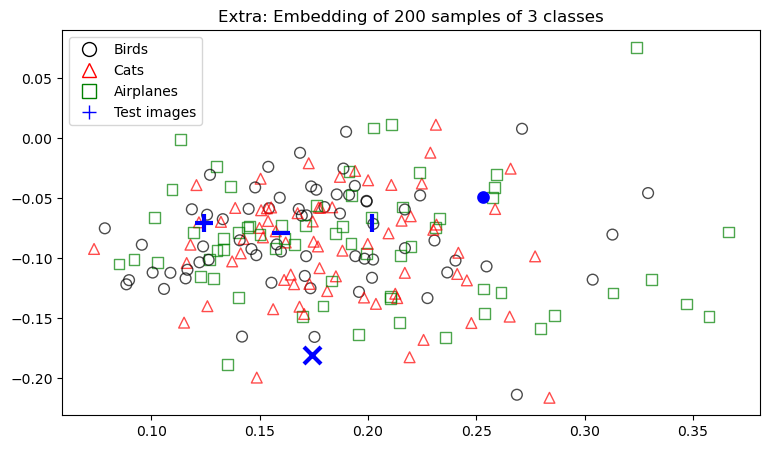

In [17]:
# Extra: Draw again with distinguish symbols for new images
plt.figure(figsize = (9,5))
plt.title('Extra: Embedding of 200 samples of 3 classes')
plt.legend(handles=[class2, class1, class0, classTest])

for data, targets in train_Loader: # Each batch has 5 samples
    image, features_bottleNeck = modelAE(data)
    table = pd.DataFrame(features_bottleNeck.detach())
    table['target'] = targets
    table['color']  = table['target'].replace(colours)
    table['symbol'] = table['target'].replace(symbols)
    for idx in range(len(table)):
        plt.scatter(table[0][idx], table[1][idx], marker = table['symbol'][idx],
                    edgecolor = table['color'][idx], facecolor = 'none', 
                    alpha = 0.7, s = 60)

test_symbol = ['|', '.', '_', '+', 'x']
for idx in range(len(tableTest)):
    plt.scatter(tableTest[0][idx], tableTest[1][idx], marker = test_symbol[idx],
                color = 'b', s = 150, linewidths=3)

# Check the labels and the corresponding symbols in the graph above
print(test_symbol)
print(targets_test) # 0, 1, 2 is Airplane, Cat, Bird respectively

**Note: using different markers to see easily check and compare it to the actual labels**
- Sample 1 (marker **|** ): is nearest to class Airplane and Bird so it could be either one of two. Luckily, it is actually belong to class Bird, although there are more classes Cat surrounding. 
- Sample 2 (marker **.** ): is closest to 3 Airplane images but just 1 Cat picture. However, it is actually a Cat image. 
- Sample 3 (marker **_** ): might be classified into class Airplane or Cat, with the dominance of class Cat. However, it turns out an Airplane image.
- Sample 4 (marker **+** ): Again, it lies between Bird and Cat pictures with close proximity to Cat image. But this image is in fact a Bird picture.
- Sample 5 (marker **x** ): Although is specifically nearest to class Bird, and in this situation, kNN = 1 would be the best since it is really class Bird.

Despite giving me relatively high accuracy in prediction solely by looking a the graph, this graph is not good enough for me to do the classification task, meaning no clear and distinguisable cluster of pattern can be found. The possible reason could be it might just is used to serve its own task, which is reconstructing the image.

## Assignment 2 - Bonus Task
Build a supervised manifold learning model on CIFAR-10 images. The main idea is to incorporate labels information in the manifold learning process. It is very similar to LDA (linear discriminant analysis) in terms of functionality. However, instead of a linear function, we use neural networks autoencoder as the backbone for manifold learning. Therefore, The model is a combination of autoencoder and classification, i.e. incorporating supervision information in the modelling process, for example, adding classification cost function into original autoencoder cost function. Do task 1-4 (see above) but replace the autoencoder by this supervised one.

### Task 1: Randomly select 3 classes with 100 images per class for this assignment

In [21]:
# Loading data
torch.manual_seed(124) # Constant seed
dataset = CIFAR10(os.getcwd(), transform = transforms.ToTensor(), download = True)

random.seed(2002)
classes = random.sample(range(9),3)
classes # Classes Airplane (0), Dog (5), Frog (6)

Files already downloaded and verified


[0, 5, 6]

In [22]:
# Check the target before changing
print(dataset.targets[0:30])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0]


In [23]:
# Change target 0,5,6 into 0,1,2 that will easily deal when working classification
# New target of Cars is 11 so can putting Dog to target 1 (Old one is 5)
dataset.targets = [11 if target == 1 else target for target in dataset.targets]
dataset.targets = [1  if target == 5 else target for target in dataset.targets]
# New target of Birds is 12 so can putting Frog to target 2 (Old one is 6)
dataset.targets = [12 if target == 2 else target for target in dataset.targets]
dataset.targets = [2  if target == 6 else target for target in dataset.targets]

In [24]:
# Check the target after changing
print(dataset.targets[0:30])

[2, 9, 9, 4, 11, 11, 12, 7, 8, 3, 4, 7, 7, 12, 9, 9, 9, 3, 12, 2, 4, 3, 2, 2, 12, 2, 3, 1, 4, 0]


In [25]:
class1_index = list(np.where( np.array(dataset.targets) == 0)[0])[0:100] # 100 row index for Airplane
class2_index = list(np.where( np.array(dataset.targets) == 1)[0])[0:100] # 100 row index for Dog  (Used to be 5)
class3_index = list(np.where( np.array(dataset.targets) == 2)[0])[0:100] # 100 row index for Frog (Used to be 6)
allClasses_index = class1_index + class2_index + class3_index # List but in order: Airplane, Dog, Frog

# Shuffle the list above to make 3 classes distribute randomly
for i in range(20):
    random.Random(i).shuffle(allClasses_index)

# Extract the table with selected indexes
dataset_filtered = torch.utils.data.Subset(dataset, allClasses_index)

In [26]:
# Divide into 3 dataset with proportion 200-95-5
trainingSet, validatingSet, testingSet = torch.utils.data.random_split(dataset_filtered, [200,95,5])

# Load data
train_Loader    = torch.utils.data.DataLoader(trainingSet  , batch_size = 5, shuffle = True) 
validate_Loader = torch.utils.data.DataLoader(validatingSet, batch_size = 5, shuffle = True) 
test_Loader     = torch.utils.data.DataLoader(testingSet   , batch_size = 5, shuffle = False)

### Task 2: Build the autoencoder model using CNN with functioning training code
Some formulae:
- Conv2d: $Output Size = \frac{Input Size + 2 \times Padding - Kernel Size}{Stride} + 1$
- $Stride$ is $1$ if it is not mentioned
- $Padding$ is $0$ if it is not mentioned
- Choose $3\times 3$ for $KernelSize$ to have more optimal object detection

In [28]:
class MLP_Classification(nn.Module): 
    def __init__(self):
        super(MLP_Classification, self).__init__()
        
        # Original Format: 3 channels, Size 32 x 32
        self.extract_feature = nn.Sequential( # Use nn.Conv2d for feature extraction and downsampling
            # Orginally 3 x (32 x 32)
            nn.Conv2d(in_channels=3 , out_channels=32, kernel_size=3, padding=1), # 32 x (32 x 32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True), # Replace negative value with 0
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # 32 x (32 x 32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            # Reduce spacial dimensionality and Capture the most significant value
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 x (16 x 16)
            nn.Dropout(p=0.3), # Randomly set 30% of units to 0

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64 x (16 x 16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # 64 x (16 x 16)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 x (8 x 8)
            nn.Dropout(p=0.3),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128 x (8 x 8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), # 128 x (8 x 8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 x (4 x 4)
            nn.Dropout(p=0.3),
            ) # Then flatten step for bottle neck layer
            
        # Requirement satisfied: Fix 2 unit in the bottle neck layer
        self.bottle_neck = nn.Sequential(
            nn.Linear(128*4*4, 2), # Compress
        )
        
        self.classify = nn.Sequential(
            nn.Linear(128*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x): 
        x = self.extract_feature(x)

        x = x.view(x.size(0), -1) # Flatten
        feature = self.bottle_neck(x)

        x = self.classify(x)

        return x, feature

Starting training cycles.
Epoch: 0 	Training Loss: 1.086350 	Validation Loss: 1.074174
Validation loss decreased (inf --> 1.074174).  Saving model ...
Epoch: 1 	Training Loss: 1.001157 	Validation Loss: 0.974122
Validation loss decreased (1.074174 --> 0.974122).  Saving model ...
Epoch: 2 	Training Loss: 0.964626 	Validation Loss: 0.907853
Validation loss decreased (0.974122 --> 0.907853).  Saving model ...
Epoch: 3 	Training Loss: 0.927560 	Validation Loss: 0.904309
Validation loss decreased (0.907853 --> 0.904309).  Saving model ...
Epoch: 4 	Training Loss: 0.906246 	Validation Loss: 0.887635
Validation loss decreased (0.904309 --> 0.887635).  Saving model ...
Epoch: 5 	Training Loss: 0.873826 	Validation Loss: 0.901210
Epoch: 6 	Training Loss: 0.874607 	Validation Loss: 0.841053
Validation loss decreased (0.887635 --> 0.841053).  Saving model ...
Epoch: 7 	Training Loss: 0.839535 	Validation Loss: 0.829679
Validation loss decreased (0.841053 --> 0.829679).  Saving model ...
Epoch: 8

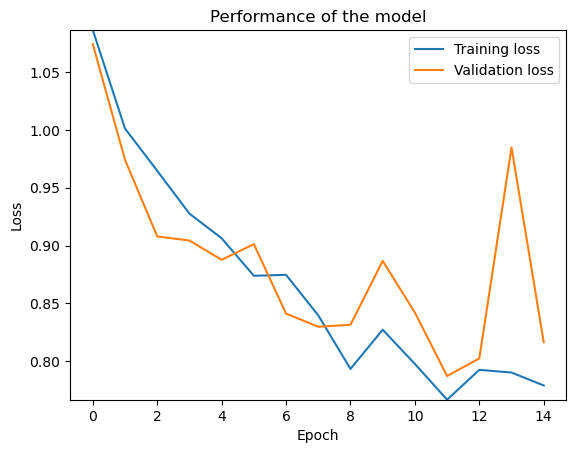

Training process has finished.


In [29]:
modelClassify = MLP_Classification()
optimiser = torch.optim.SGD(modelClassify.parameters(), lr=0.01)

train_model(optimiser, modelClassify, nn.CrossEntropyLoss(),    
            train_Loader, validate_Loader, mode = 'Classification', 
            n_epochs=15, fplotloss=True, filename='_classification')

Only run 15 epochs (unlike Autoencoder, 50 epochs) to avoid overfitting to the training dataset.

In [31]:
# Load the parameter that make loss minimum in the previous iterations
state_dict = torch.load('bestmodelAE_classification.pt')
model_dict = modelClassify.state_dict()
modelClassify.load_state_dict(model_dict)

<All keys matched successfully>

In [32]:
# Change a bit compared to the tutorial since cannot put result in argmax form to the argument
def calculate_accuracy(y_pred, y): # Get accuracy manually
    if y_pred.shape[1] > 1: # When it is not converted to labels yet (softmax form)
        top_pred = y_pred.argmax(1, keepdim=True)
    else: top_pred = y_pred # When it is already label form          (argmax  form)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc, top_pred

In [33]:
# TRAINING DATASET ###########################################################
for i, data in enumerate(train_Loader): # Test dataset only include 5 samples
    inputs, targets = data
    acc, y_predict = calculate_accuracy(modelClassify(inputs)[0], targets)
    if i==0:
        predy = y_predict
        truey = targets
    else: 
        predy =torch.cat((predy,y_predict))
        truey = torch.cat((truey,targets))

acc,_ = calculate_accuracy(predy,truey)  
print("Total accuracy of training: ", acc.detach().numpy())

# VALIDATING DATASET ###########################################################
for i, data in enumerate(validate_Loader): # Test dataset only include 5 samples
    inputs, targets = data
    acc, y_predict = calculate_accuracy(modelClassify(inputs)[0], targets)
    if i==0:
        predy = y_predict
        truey = targets
    else: 
        predy =torch.cat((predy,y_predict))
        truey = torch.cat((truey,targets))

acc,_ = calculate_accuracy(predy,truey)  
print("Total accuracy of validating: ", acc.detach().numpy())

# TESTING DATASET ###########################################################
for i, data in enumerate(test_Loader): # Test dataset only include 5 samples
    inputs, targets = data
    acc, y_predict = calculate_accuracy(modelClassify(inputs)[0], targets)
    if i==0:
        predy = y_predict
        truey = targets
    else: 
        predy =torch.cat((predy,y_predict))
        truey = torch.cat((truey,targets))

acc,_ = calculate_accuracy(predy,truey)  
print("Total accuracy of testing: ", acc.detach().numpy())

Total accuracy of training:  0.83
Total accuracy of validating:  0.7157895
Total accuracy of testing:  1.0


- With the graph 'Performance of the model', just choose 15 for the number of epochs to prevent overfitting.
- The accuracy rate of 3 datasets seems to be enough, especially it produces 100% prediction for the unknown testing dataset.

### Task 3: Plot the learnt images 2D coordinates (normally called embeddings in machine learning) of all images in training with each class denoted by a symbol.

### Task 4: Randomly select 5 images that are not in the training set and obtain their 2D representations, add them to the plot produced in task 3 and describe what do you think about them in terms of their locations in relations to others.

In [36]:
print('Before change:', classes) # But remember that class 5 changed into 1, 6 into 2
classes[1] = 1
classes[2] = 2
print('After change :', classes)

Before change: [0, 5, 6]
After change : [0, 1, 2]


In [37]:
symbols = {0: 's', 1: '^', 2: 'o'}
colours = {0: 'g', 1: 'r', 2: 'k'}

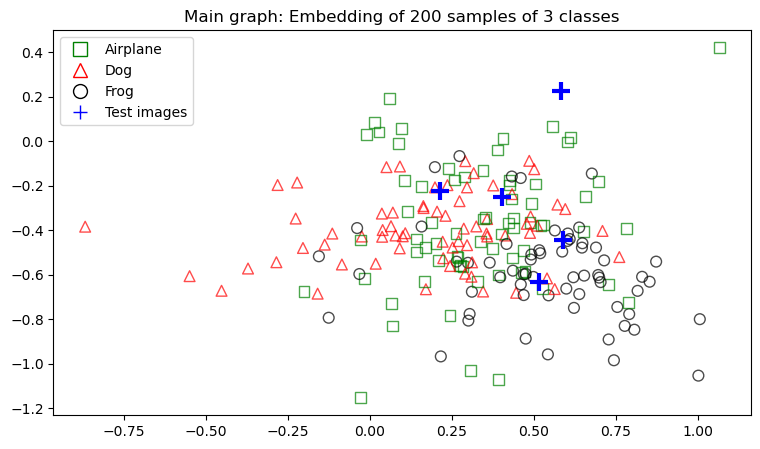

In [38]:
class0 = plt.Line2D([0], [0], marker='s', color='g', label='Airplane', 
                    linestyle='none', markerfacecolor='none', markersize=10)
class1 = plt.Line2D([0], [0], marker='^', color='r', label='Dog', 
                    linestyle='none', markerfacecolor='none', markersize=10)
class2 = plt.Line2D([0], [0], marker='o', color='k', label='Frog', 
                    linestyle='none', markerfacecolor='none', markersize=10)
# Using '+' to represent all the 
classTest = plt.Line2D([0], [0], marker='+', color='b', label='Test images', 
                       linestyle='none', markerfacecolor='none', markersize=10)

plt.figure(figsize = (9,5))
plt.title('Main graph: Embedding of 200 samples of 3 classes')
plt.legend(handles=[class0, class1, class2, classTest])

# Task 3: Training Data
for data, targets in train_Loader: # Each batch has 5 samples
    image, features_bottleNeck = modelClassify(data)
    table = pd.DataFrame(features_bottleNeck.detach())
    table['target'] = targets
    table['color']  = table['target'].replace(colours)
    table['symbol'] = table['target'].replace(symbols)
    for idx in range(len(table)):
        plt.scatter(table[0][idx], table[1][idx], marker = table['symbol'][idx],
                    edgecolor = table['color'][idx], facecolor = 'none', 
                    alpha = 0.7, s = 60)

# Task 4: Testing Data
for data, targets_test in test_Loader:
    image, features_bottleNeck = modelClassify(data)
    tableTest = pd.DataFrame(features_bottleNeck.detach())
    for idx in range(len(tableTest)):
        plt.scatter(tableTest[0][idx], tableTest[1][idx], marker = '+',
                    color = 'b', s = 150, linewidths=3)

The graph is much clearer than the graph in the Autoencoder part. 
- However, class Airplane is not transparent enough because it is distributed widely among the graph, which is hard to classify.
- Luckily, class Dog and Frog are really easily distinguishable (which is personally suggested using an orange line in the below graph). 

['|', '.', '_', '+', 'x']
tensor([2, 1, 0, 0, 2])


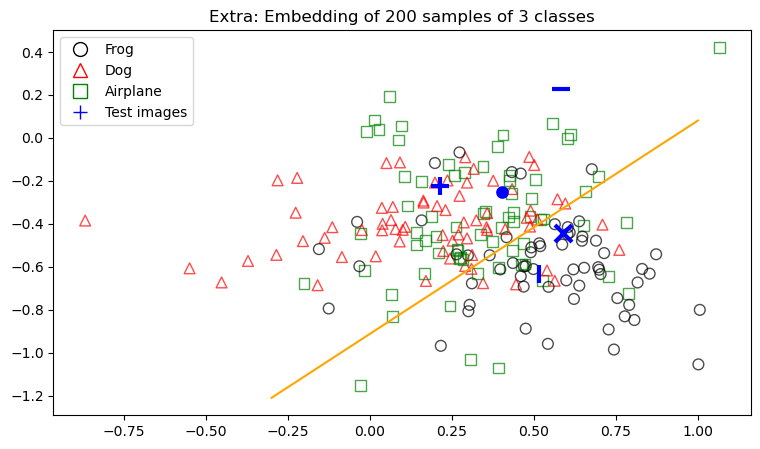

In [40]:
# Extra: Draw again with distinguish symbols for new images
plt.figure(figsize = (9,5))
plt.title('Extra: Embedding of 200 samples of 3 classes')
plt.legend(handles=[class2, class1, class0, classTest])

for data, targets in train_Loader: # Each batch has 5 samples
    image, features_bottleNeck = modelClassify(data)
    table = pd.DataFrame(features_bottleNeck.detach())
    table['target'] = targets
    table['color']  = table['target'].replace(colours)
    table['symbol'] = table['target'].replace(symbols)
    for idx in range(len(table)):
        plt.scatter(table[0][idx], table[1][idx], marker = table['symbol'][idx],
                    edgecolor = table['color'][idx], facecolor = 'none', 
                    alpha = 0.7, s = 60)

test_symbol = ['|', '.', '_', '+', 'x']
for idx in range(len(tableTest)):
    plt.scatter(tableTest[0][idx], tableTest[1][idx], marker = test_symbol[idx],
                color = 'b', s = 150, linewidths=3)

# Suggestion of the border line for Dog and Frog
x_line = np.linspace(-0.3, 1, 1000)
y_line = 0.993 * x_line - 0.9121
plt.plot(x_line, y_line, color='orange')


# Check the labels and the corresponding symbols in the graph above
print(test_symbol)
print(targets_test) # 0, 1, 2 is Airplane, Dog, Frog respectively

**Note: using different markers to see easily check and compare it to the actual labels**

With the suggestion using the orange line (border of class Dog and class Frog in my opinion):
- Sample 1 (marker **|** ): although its specific coordinates is sort of chaos due to the unclear pattern, we can manage to predict it as a Frog image because it is to the right side of the border line where is assigned for class Frog.
- Sample 2 (marker **.** ): is found also on the left side of the border line. However, it could be either a image of a dog or an airplane because the unclear surrounding pattern. But at the end, it still ends up being labelled as a Dog image.
- Sample 3 (marker **_** ): is located one top area of the graph, where only class Airplane can be found. In fact, the model does work well since it well locates this new image to the good position in the graph.
- Sample 4 (marker **+** ): while most of other images is located in a good position, this one despite being placed in the middle of class Dog, it turns out being class Airplane.
- Sample 5 (marker **x** ): is positioned to the right of the border line and is surrounded by mostly Frog images, is is suggested to be a Frog class, and indeed it is.

Hence, this specific model work more effectively in classifying the sample when it could give out a clear pattern in the graph. However, it should need to be investigated more and modified so it could help user to distinguish sample by just the bottle neck layer.